## ** A New Non-intrusive Load Monitoring Method for Residential Appliances **

 - Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
 - Description
   * We examine the pre-verification of candidate appliances in which appliances that cannot be recognized by NILM are excluded. 
   Pre- verification is performed prior to NILM model development. NILM models can only work when the training data they receive is 
   produced by appliances with consistent electrical consumption patterns. This was confirmed using the dynamic time warping (DTW) 
   technique, which is better suited than the Euclidian distance method even if the lengths or starting points of the comparison targets 
   are different
 - License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

In [1]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error
from work.rnndisaggregator_fe import RNNDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

C:\ProgramData\Anaconda3\envs\nilm\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


## [1] Reproducibility Check

- Description
  The same operations were repeated to determine whether the appliances in question consumed consistent amounts of electricity. First, each 
  energy consumption data unit from activation to deactivation was extracted for a given appliance and then DTW distances were calculated 
  for each pair of data.

********************
[television]
********************


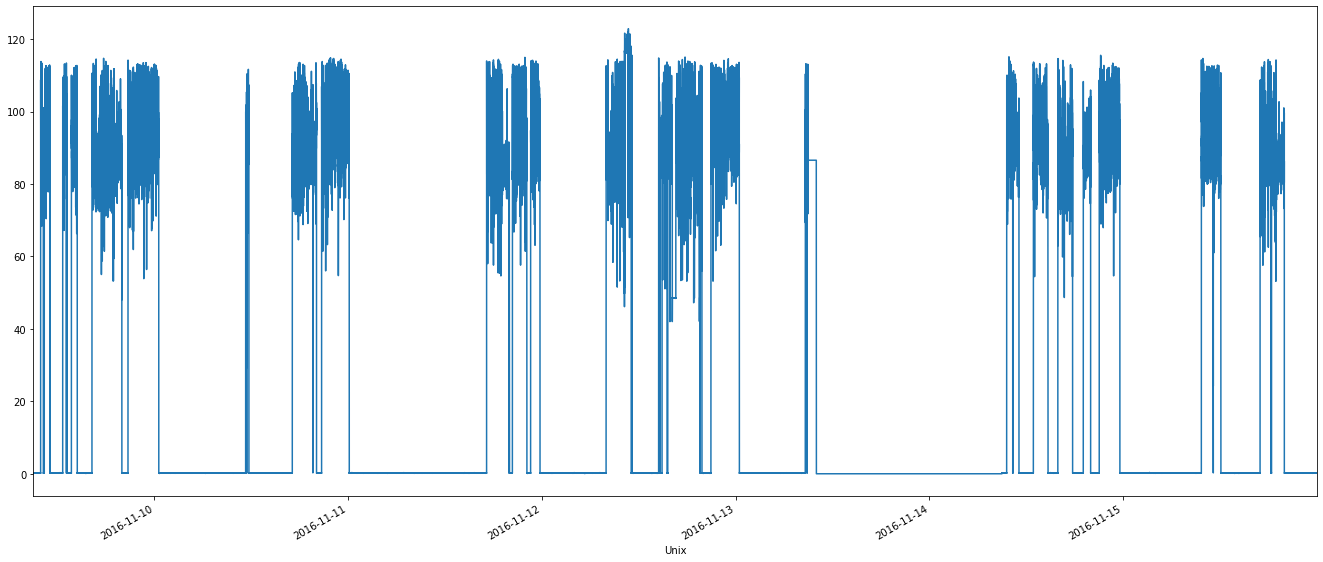

'Baseline = 27.02'

'[Average] : 6.17'

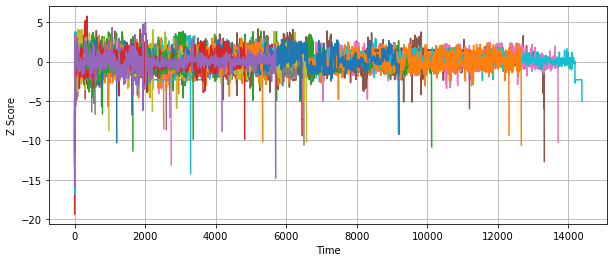

Done
********************
[washing machine]
********************


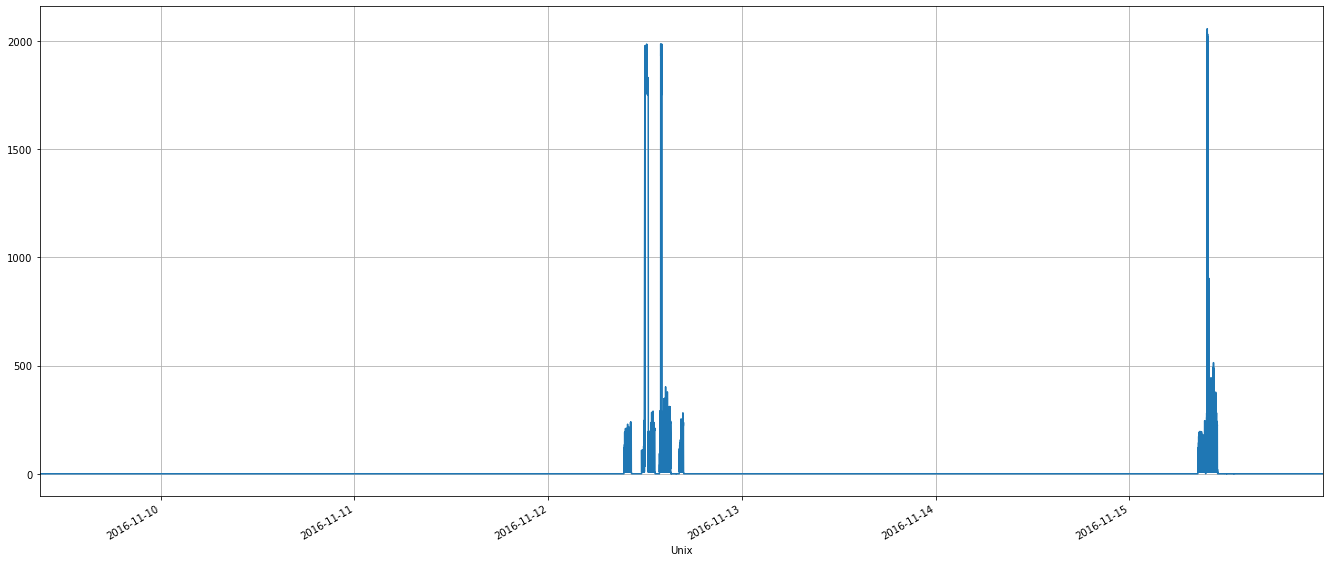

'Baseline = 67.66'

'[Average] : 0.51'

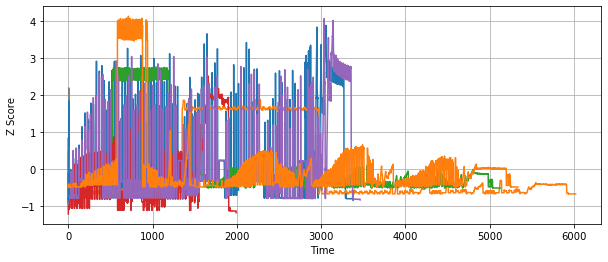

Done
********************
[rice cooker]
********************


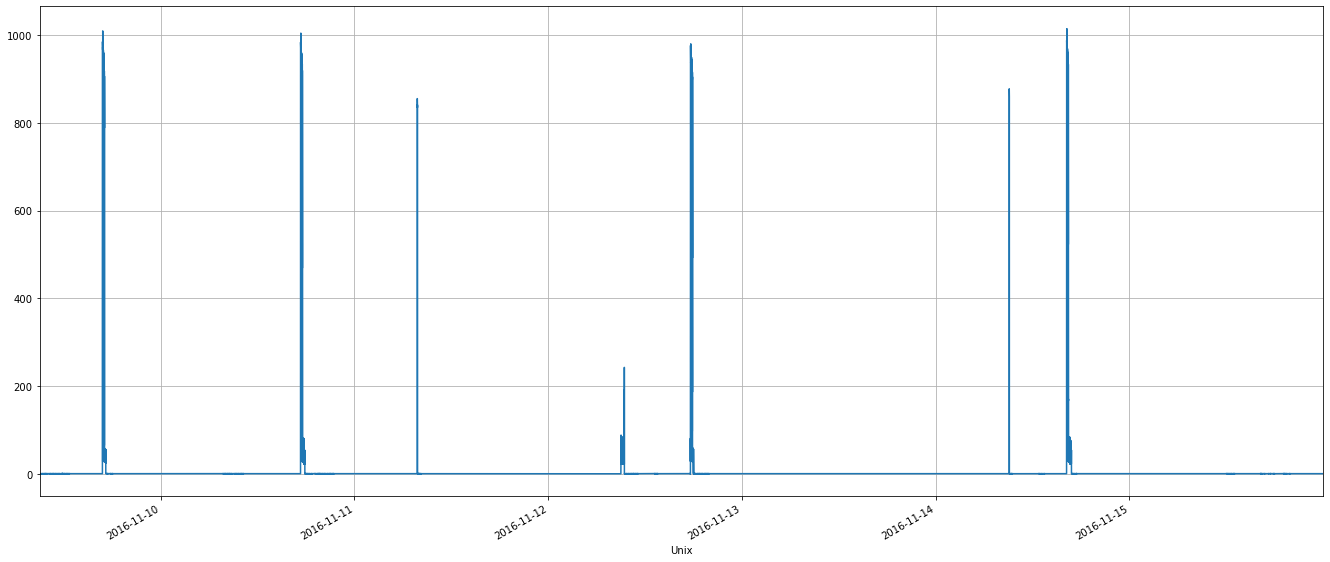

'Baseline = 11.19'

'[Average] : 5.25'

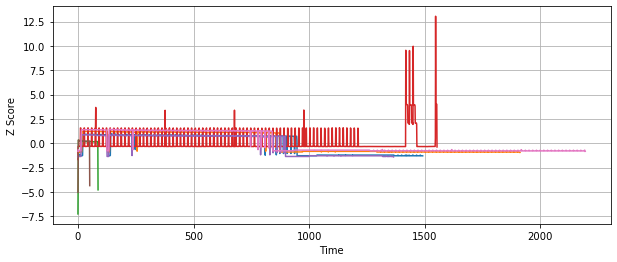

Done
********************
[water filter]
********************


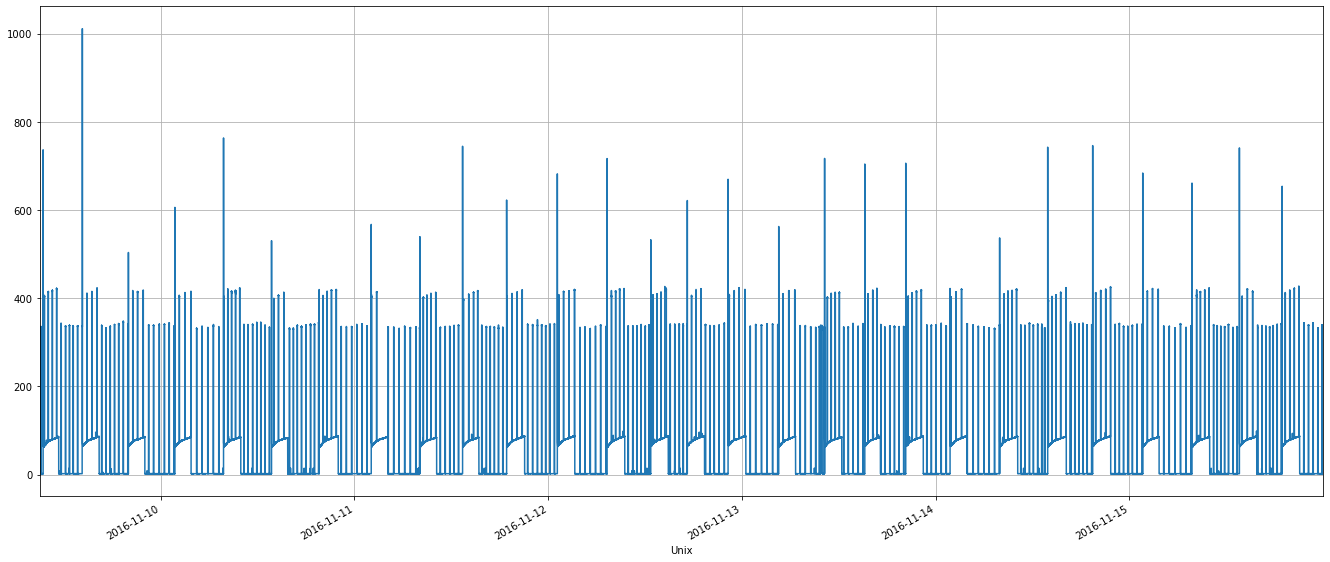

'Baseline = 135.12'

'[Average] : 35.22'

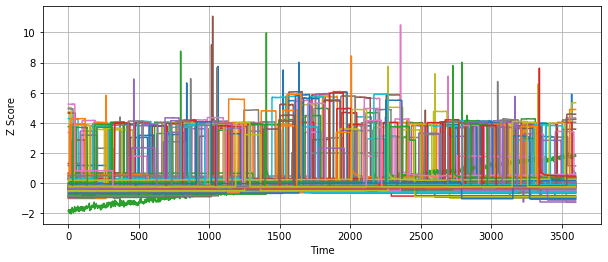

Done
********************
[microwave]
********************


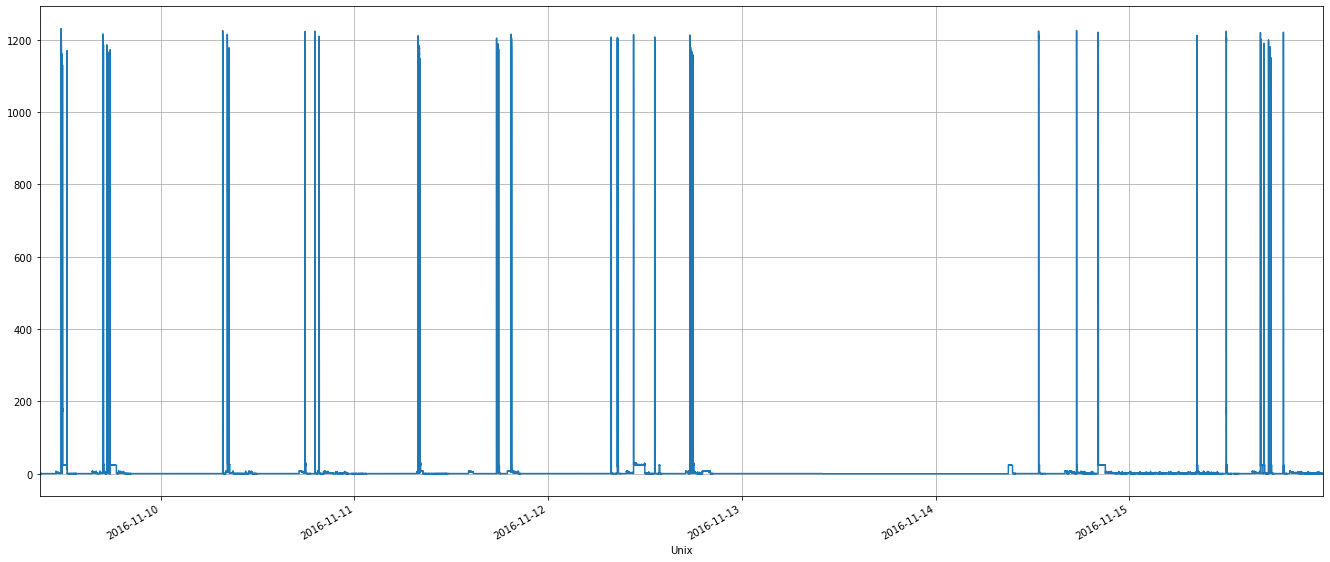

'Baseline = 18.07'

'[Average] : 1.95'

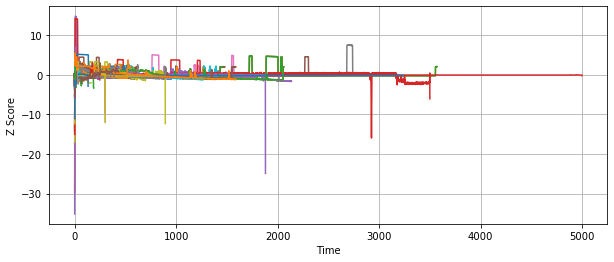

Done


In [2]:
dataset = DataSet('data/enertalk.h5')
dataset.set_window(start='2016-11-09', end='2016-11-16')

train_elec = dataset.buildings[1].elec

appliances = {'television':False, 'washing machine':False, 'rice cooker':False, 'water filter':True, 'microwave':False}

for aname, always in appliances.items():
    
    print("*"*20)
    print("[" + aname + "]") 
    print("*" *20)
    
    train_meter = train_elec.submeters()[aname]
    
    meter_power_series = train_meter.power_series(sample_period=1)
    meterchunk = next(meter_power_series)
    meterchunk.fillna(0, inplace=True)
    
    meterchunk.plot()
    plt.show()
    
    data_list = []
    data_list.append(meterchunk)
    
    checkSimilarity(data_list, always)    

## [2] Inter-similarity Check

- Description
  The similarities between energy consumption patterns of different instances of the same type of appliance were checked because, if they 
  had similar energy consumption patterns, it would be possible to build a general NILM model for that type of appliance. Otherwise NILM 
  models for the appliance in question would have to be separately developed for each house.

In [12]:
def getMeterData(home_id, appliance_name):
    
    print("*"*20)
    print("[" + str(home_id) + "] - [" + appliance_name + "]") 
    print("*" *20)
    
    train_elec = dataset.buildings[home_id].elec
    
    train_meter = train_elec.submeters()[appliance_name]
    
    meter_power_series = train_meter.power_series(sample_period=1)
    meterchunk = next(meter_power_series)
    meterchunk.fillna(0, inplace=True)
    
    meterchunk.plot()
    plt.show()
    
    return meterchunk

********************
[1] - [television]
********************


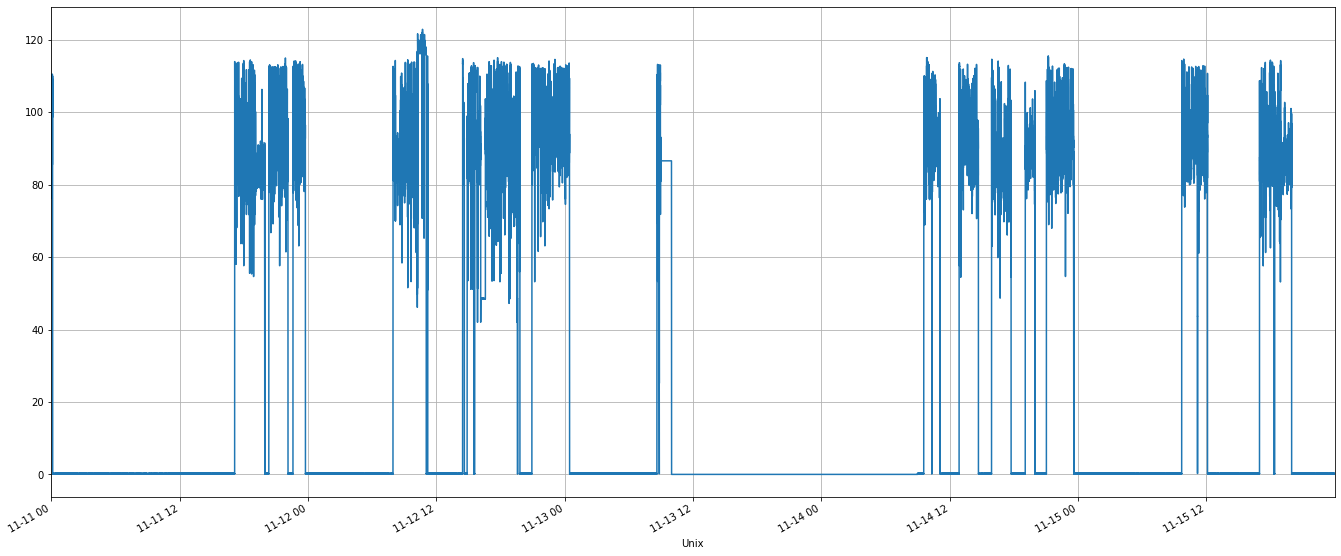

********************
[2] - [television]
********************


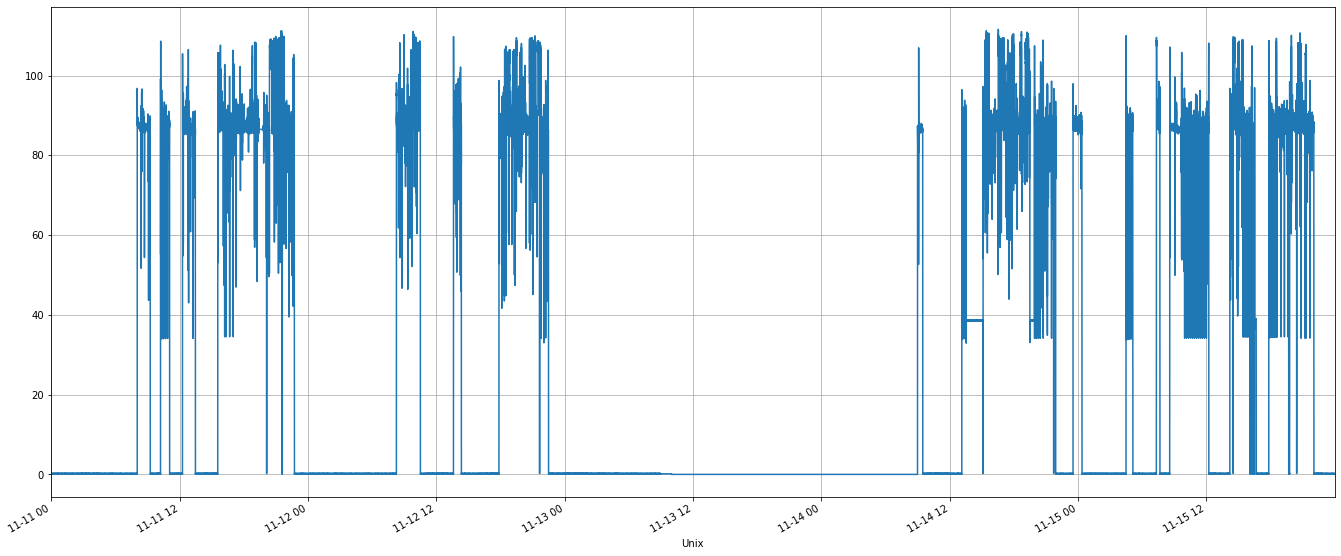

********************
[5] - [television]
********************


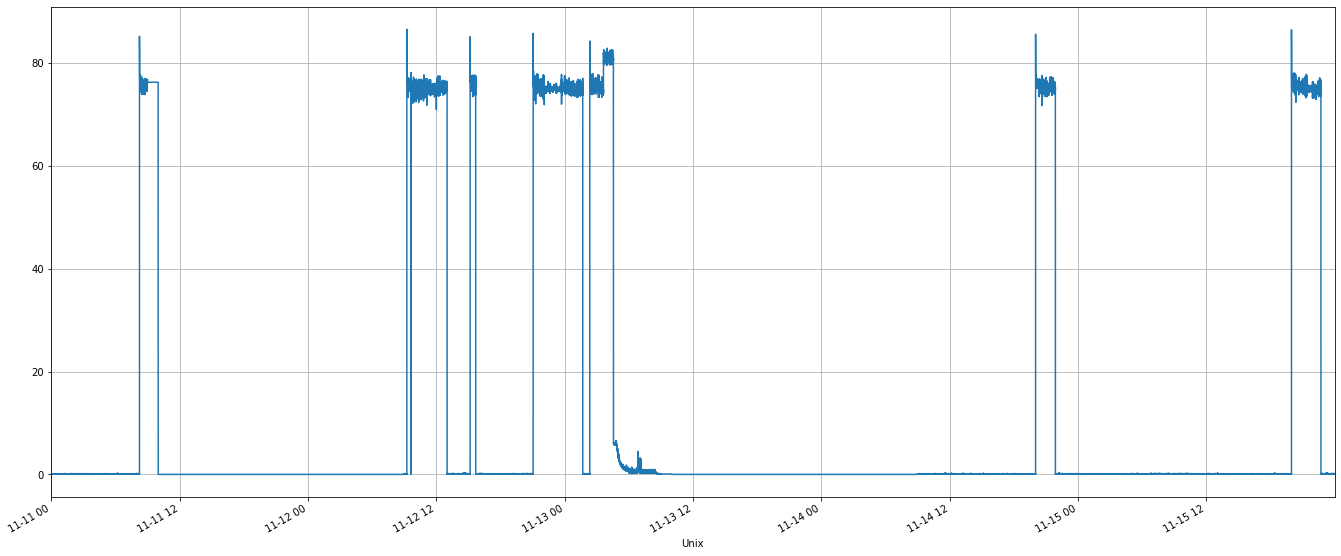

********************
[10] - [television]
********************


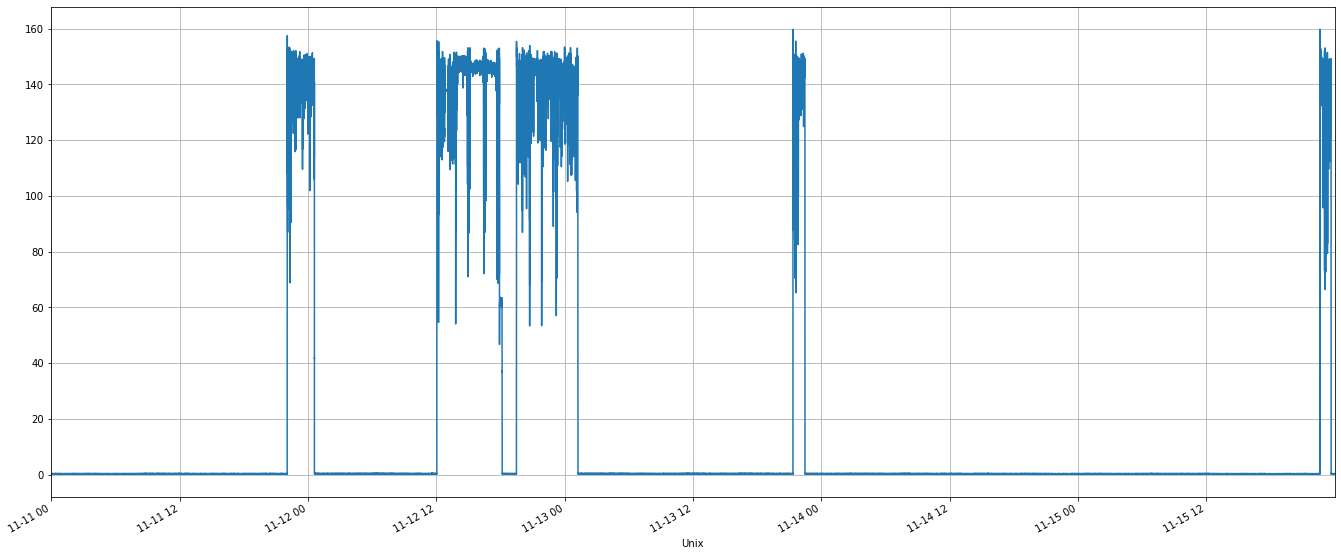

'Baseline = 4.93'

'[Average] : 15.71'

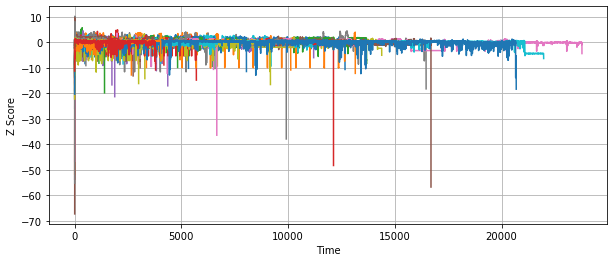

Done


In [19]:
dataset = DataSet('data/enertalk.h5')
dataset.set_window(start='2016-11-11', end='2016-11-16')

# televison
tv =[]
tv.append(getMeterData(1, "television"))
tv.append(getMeterData(2, "television"))
tv.append(getMeterData(5, "television"))
tv.append(getMeterData(10, "television"))

checkSimilarity(tv, False) 

********************
[1] - [washing machine]
********************


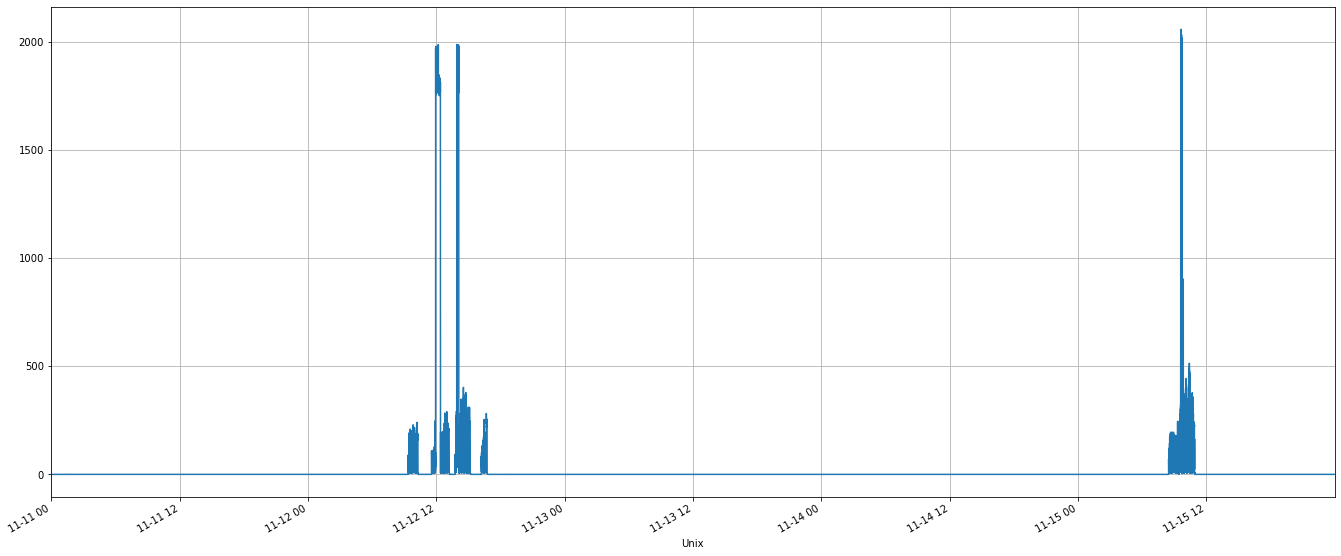

********************
[2] - [washing machine]
********************


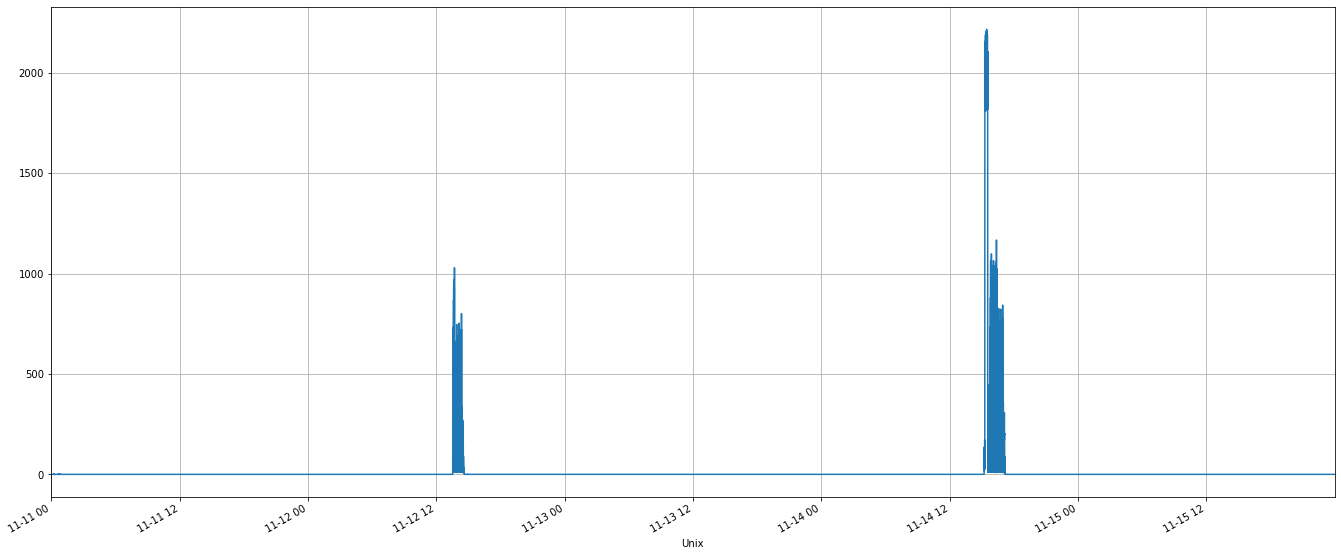

********************
[4] - [washing machine]
********************


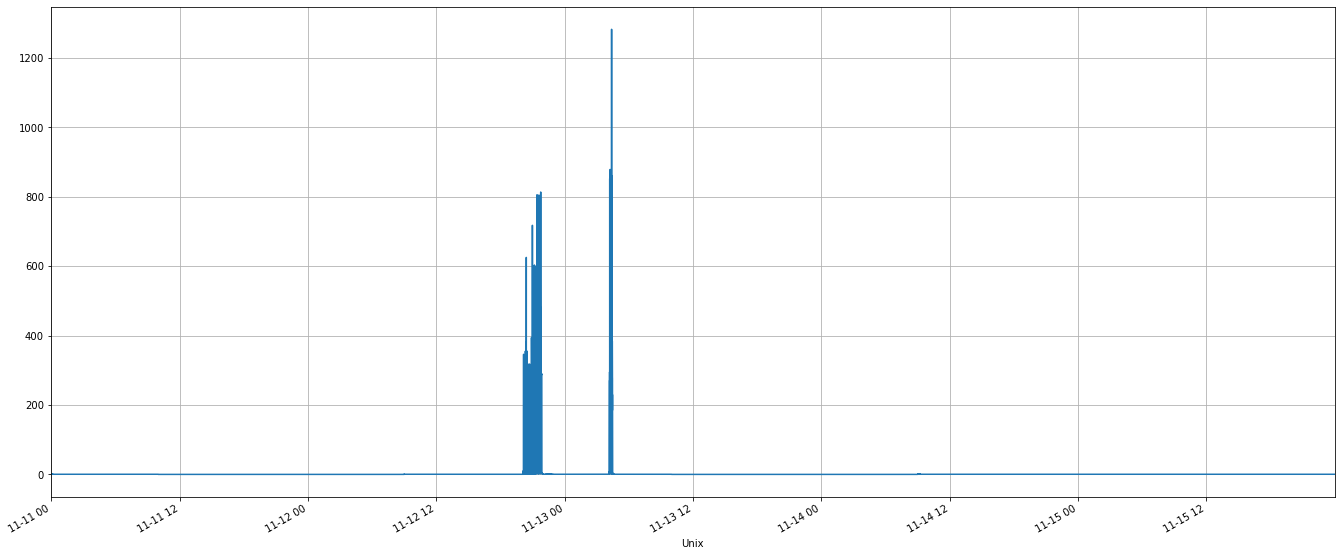

********************
[5] - [washing machine]
********************


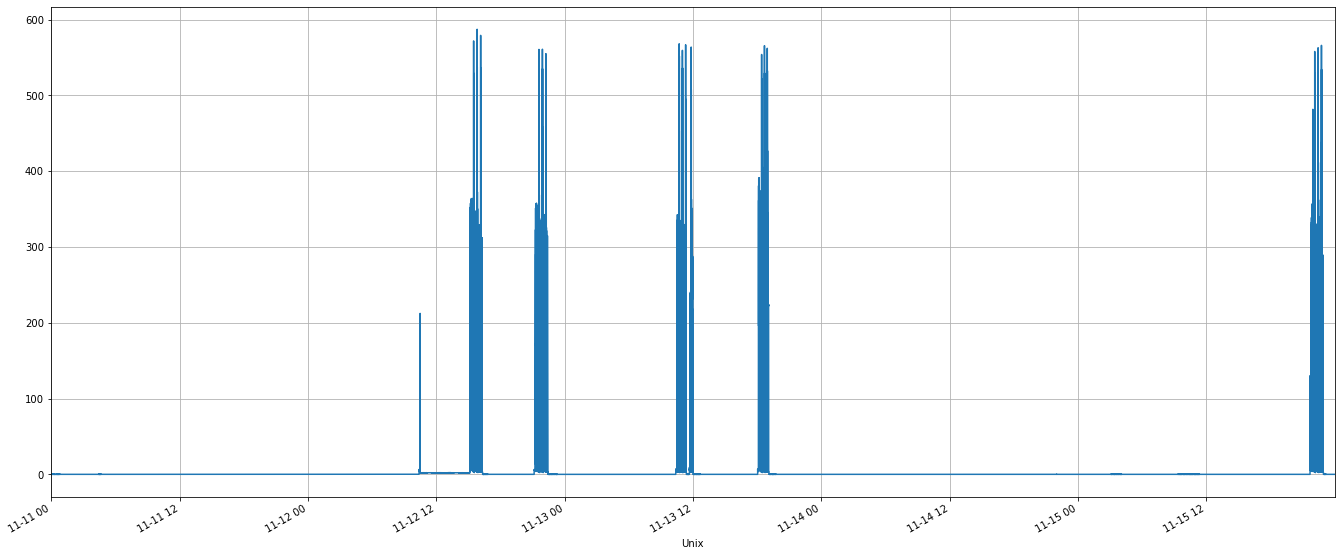

'Baseline = 67.66'

'[Average] : 1.31'

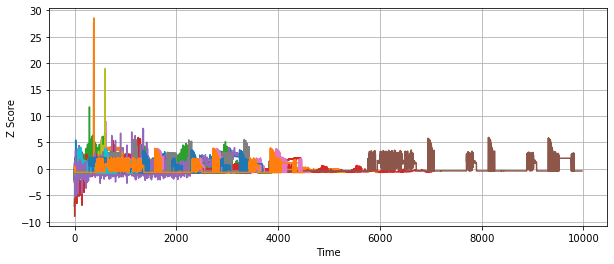

Done


In [24]:
dataset.set_window(start='2016-11-11', end='2016-11-16')

# washing machine
wm = []
wm.append(getMeterData(1, "washing machine"))
wm.append(getMeterData(2, "washing machine"))
wm.append(getMeterData(4, "washing machine"))
wm.append(getMeterData(5, "washing machine"))

checkSimilarity(wm, False) 

********************
[1] - [rice cooker]
********************


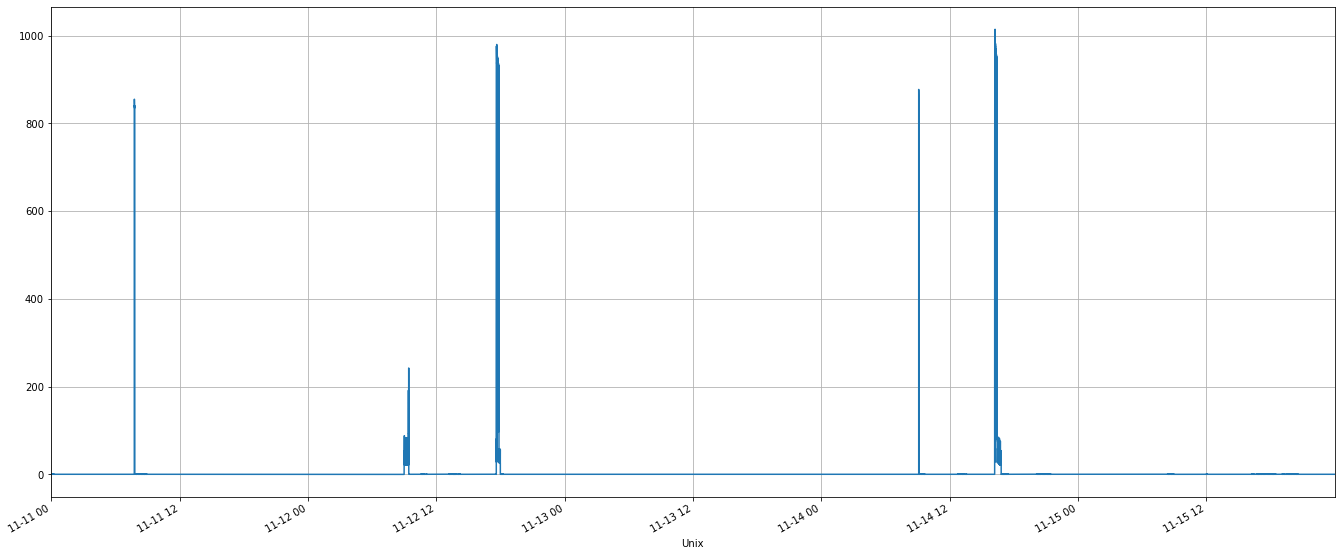

********************
[2] - [rice cooker]
********************


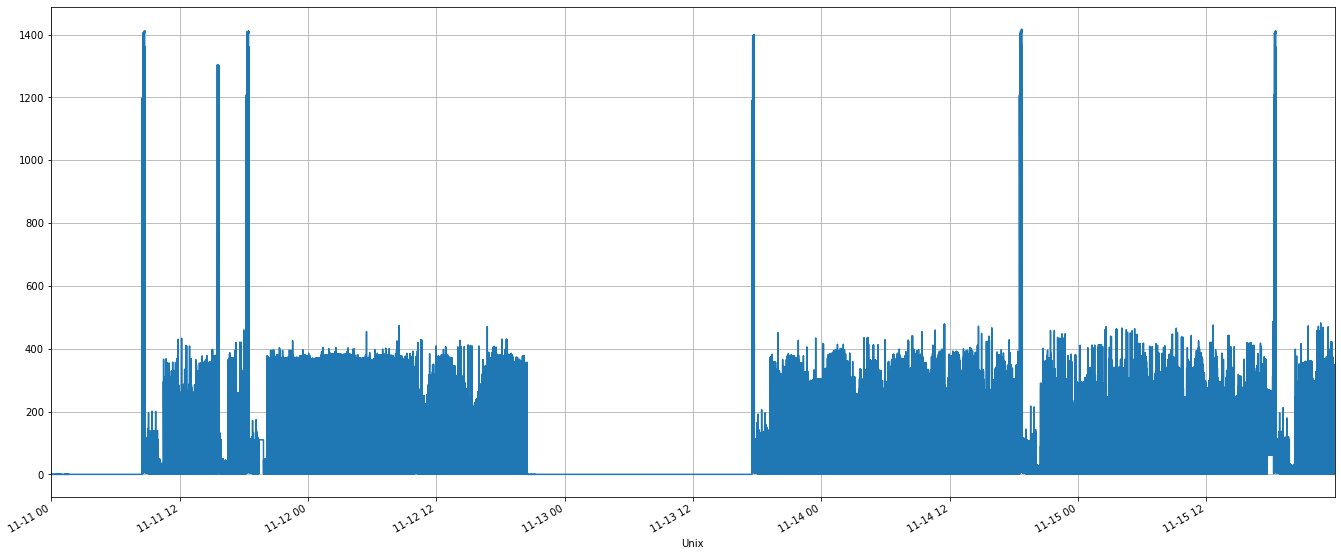

********************
[5] - [rice cooker]
********************


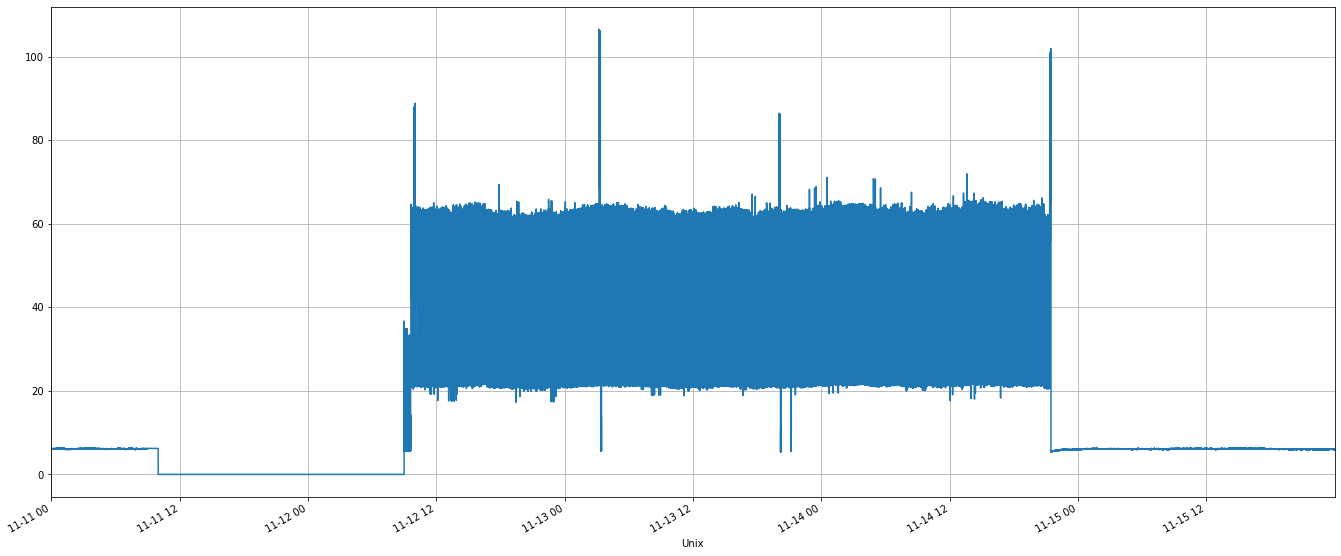

********************
[10] - [rice cooker]
********************


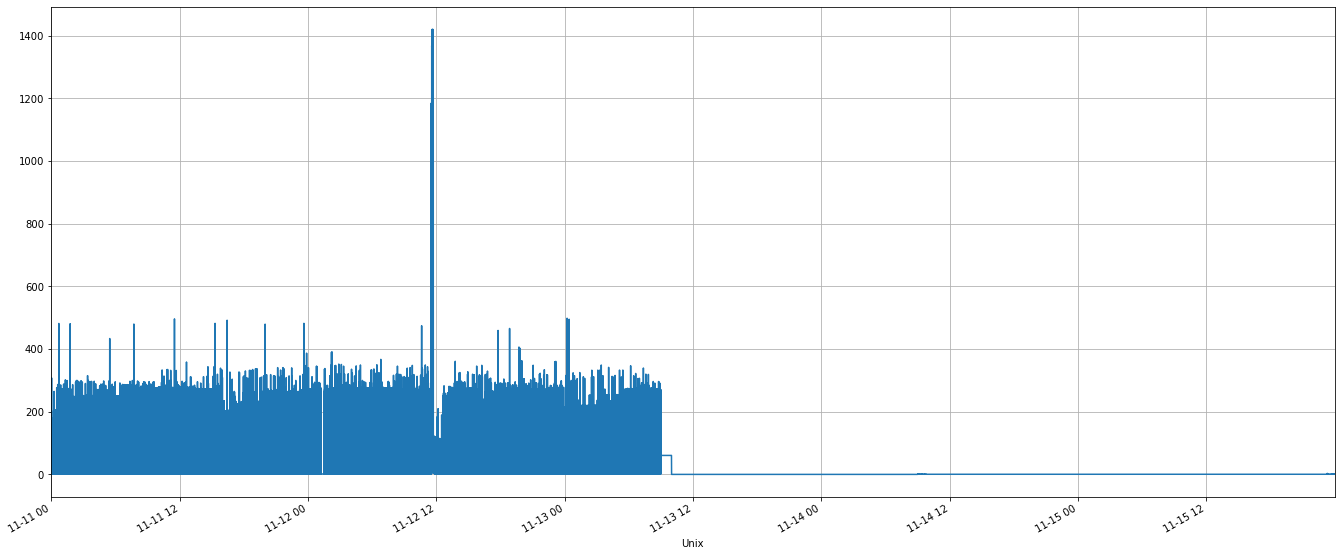

'Baseline = 0.87'

'[Average] : 7.73'

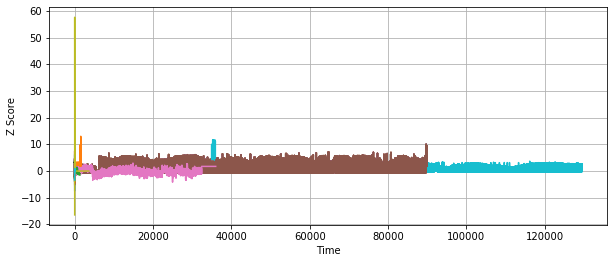

Done


In [28]:
dataset.set_window(start='2016-11-11', end='2016-11-16')

# rice cooker
rc = []
rc.append(getMeterData(1, "rice cooker"))
rc.append(getMeterData(2, "rice cooker"))
rc.append(getMeterData(5, "rice cooker"))
rc.append(getMeterData(10, "rice cooker"))

checkSimilarity(rc, False) 

********************
[1] - [water filter]
********************


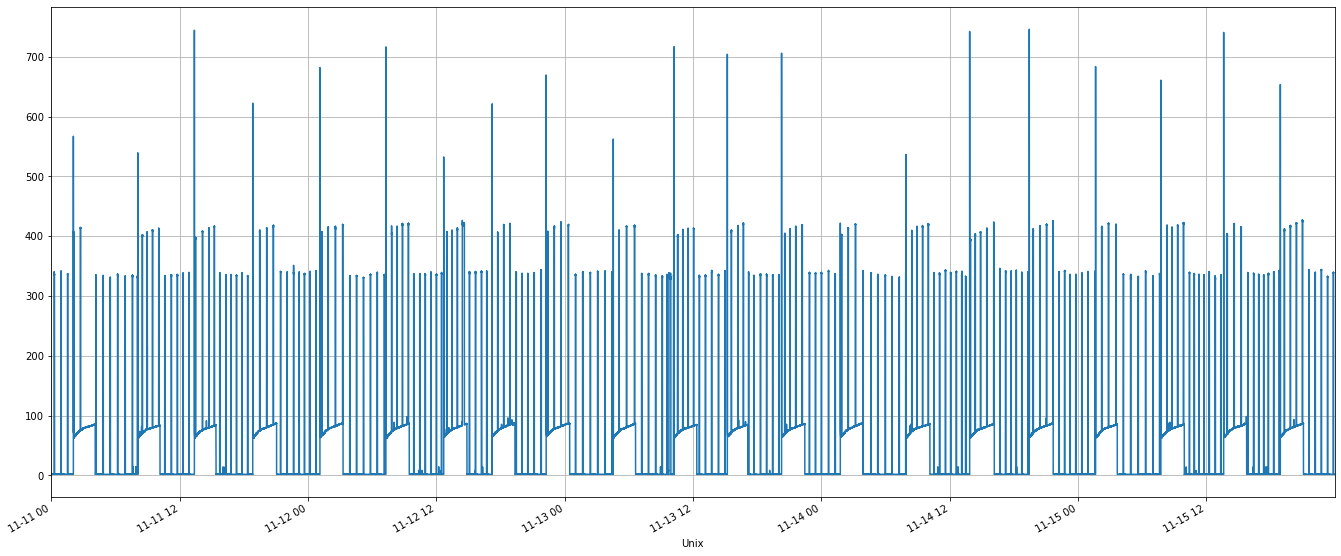

********************
[7] - [water filter]
********************


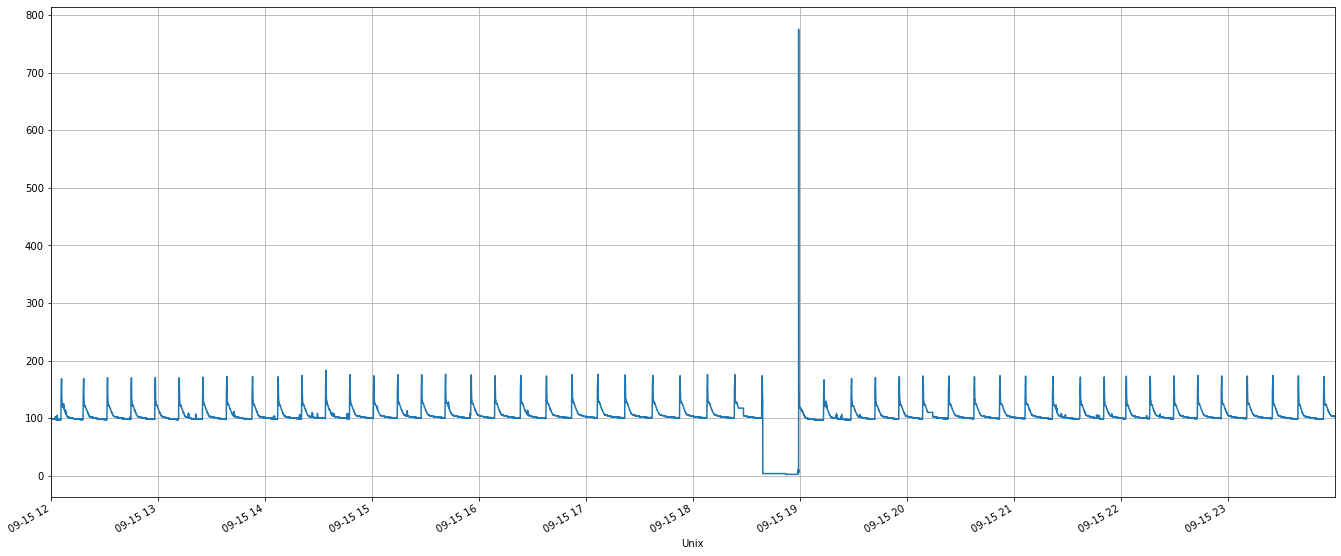

'Baseline = 72.37'

'[Average] : 26.18'

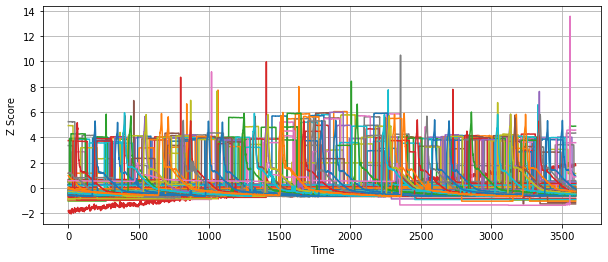

Done


In [39]:
dataset.set_window(start='2016-11-11', end='2016-11-16')

# water filter
wf = []
wf.append(getMeterData(1, "water filter"))

dataset.set_window(start='2016-09-15 12:00:00', end='2016-09-16')
wf.append(getMeterData(7, "water filter"))

checkSimilarity(wf, True) 

********************
[1] - [microwave]
********************


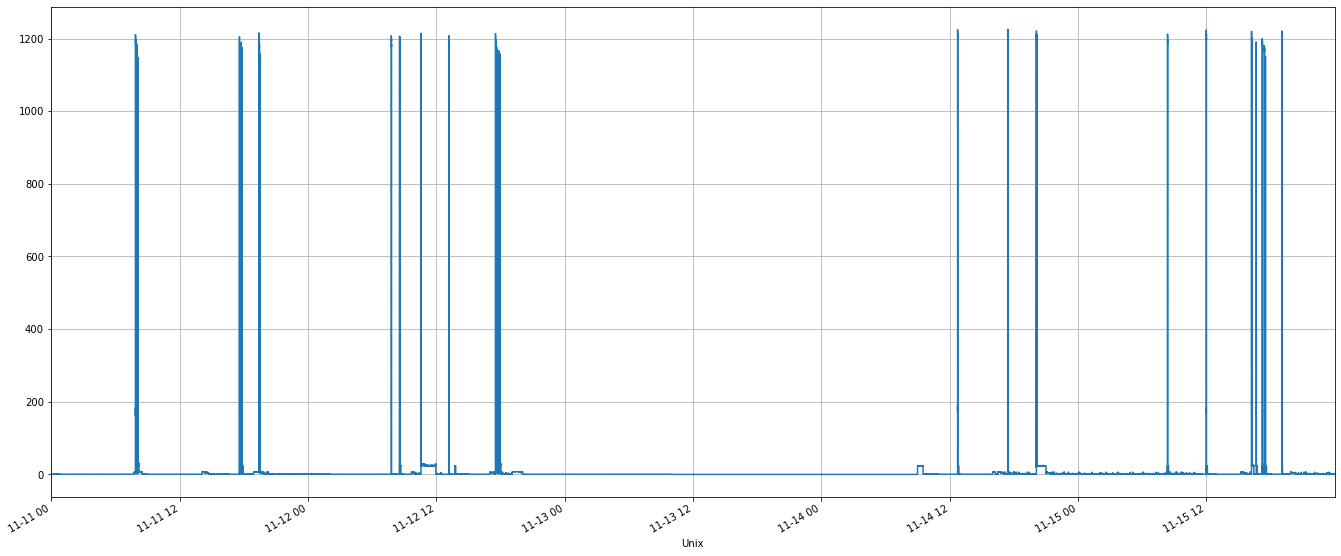

********************
[10] - [microwave]
********************


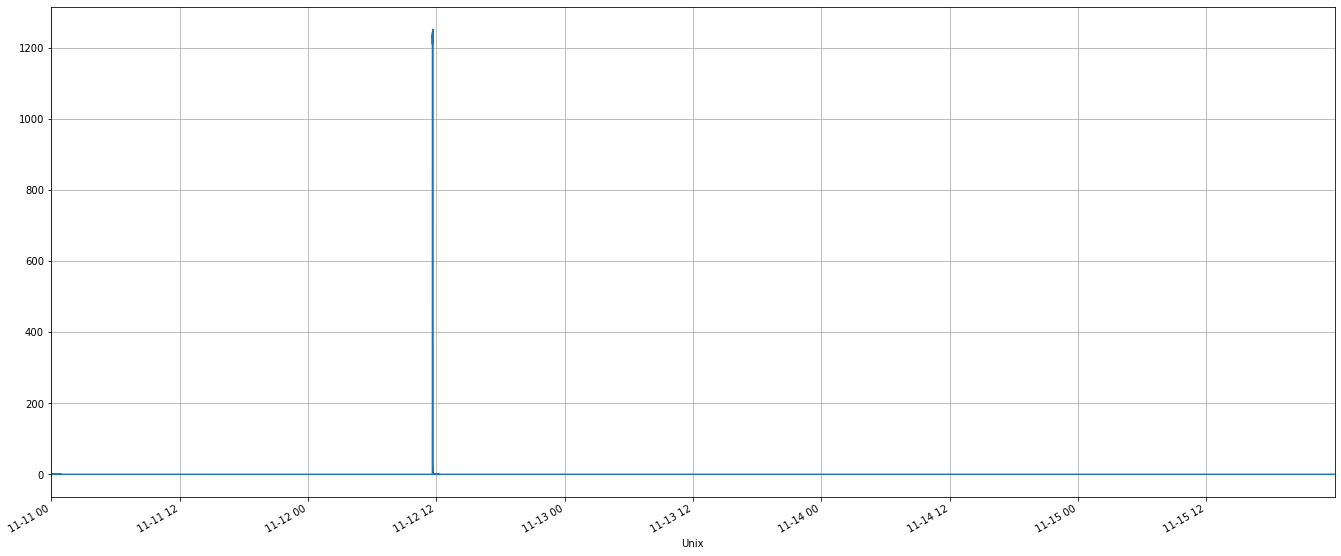

'Baseline = 58.51'

'[Average] : 2.3'

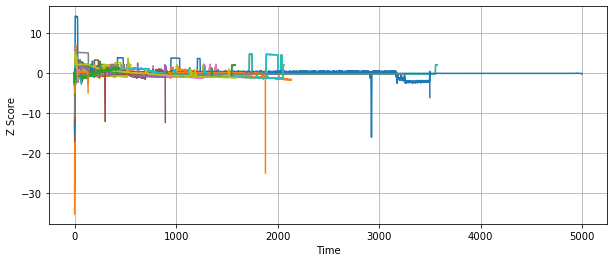

Done


In [30]:
dataset.set_window(start='2016-11-11', end='2016-11-16')

# microwave
mw = []
mw.append(getMeterData(1, "microwave"))
mw.append(getMeterData(10, "microwave"))

checkSimilarity(mw, False) 